In [61]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import keras_tuner as kt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import array_to_img


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
       tf.config.experimental.set_memory_growth(gpu,True)

In [63]:
   resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False
    )

## Creating a TensorFlow Dataset

Training on the entire CIHP dataset with 38,280 images takes a lot of time, hence we will be using
a smaller subset of 200 images for training our model in this example.

In [3]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 4
DATA_DIR = "C:/kaggletemp/sartorius-cell-instance-segmentation"
LOGS = os.path.join(DATA_DIR,'models/logs')
MODELS  = os.path.join(DATA_DIR,'models/models')
NUM_TRAIN_IMAGES = np.floor(.9 * 602).astype( "int")

NUM_VAL_IMAGES = 602 - NUM_TRAIN_IMAGES

# train_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[:NUM_TRAIN_IMAGES]
# train_masks = sorted(glob(os.path.join(DATA_DIR, "mask_one_channel_encoded/*")))[:NUM_TRAIN_IMAGES]
# val_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[
#     (NUM_TRAIN_IMAGES + 1) : (NUM_VAL_IMAGES + NUM_TRAIN_IMAGES)
# ]
# val_masks = sorted(glob(os.path.join(DATA_DIR, "mask_one_channel_encoded/*")))[
#     (NUM_TRAIN_IMAGES +1): (NUM_VAL_IMAGES + NUM_TRAIN_IMAGES)
# ]

In [4]:
glob(os.path.join(DATA_DIR,'test'))

['C:/kaggletemp/sartorius-cell-instance-segmentation\\test']

In [39]:


def readt(path, show = True):
    im = tf.io.read_file(path)
    im= tf.image.decode_png(im)
    if show:
        display( array_to_img(im))
    else:
        return im

#train_data = pd.read_csv('C:/kaggletemp/sartorius-cell-instance-segmentation/train.csv')
test = glob(os.path.join(DATA_DIR, "test/*"))
im = sorted(glob(os.path.join(DATA_DIR, "train/*")))
ms = sorted(glob(os.path.join(DATA_DIR, "mask_one_channel_encoded/*")))

data = { 'img' : im, 'mask' : ms}
td = pd.DataFrame(data= data)
td = td.sample(frac=1).reset_index(drop=True)
train_images = td['img'].iloc[:NUM_TRAIN_IMAGES]
train_masks =  td['mask'].iloc[:NUM_TRAIN_IMAGES]
val_images = td['img'].tail(len(im) - NUM_TRAIN_IMAGES)
val_masks = td['mask'].tail(len(im)-  NUM_TRAIN_IMAGES)

# val_images = td['img'].iloc[
#     (NUM_TRAIN_IMAGES + 1) : (NUM_VAL_IMAGES + NUM_TRAIN_IMAGES)
# ]
# val_masks = td['mask'].iloc[
#     (NUM_TRAIN_IMAGES +1): (NUM_VAL_IMAGES + NUM_TRAIN_IMAGES)
# ]

#sanity check

ar = readt(train_masks[0], show= False)
print(ar.shape)
ar = tf.reshape(ar, -1)
print(np.bincount(ar))
print(len(train_images), len( train_masks),len(val_images), len( val_masks))
#sanity check
#set(train_images).intersection(set(val_images)).__len__()

(520, 704, 1)
[361644      0      0   4436]
541 541 65 65


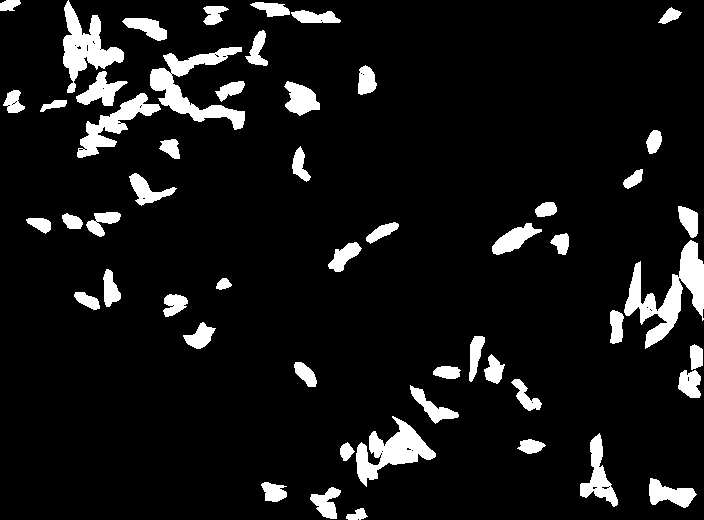

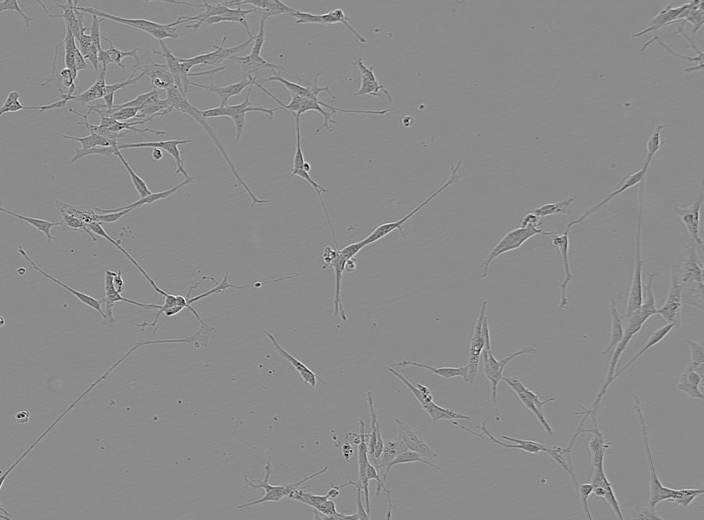

['C:/kaggletemp/sartorius-cell-instance-segmentation\\mask_one_channel_encoded\\04cd81dfb245.png',
 'C:/kaggletemp/sartorius-cell-instance-segmentation\\train\\04cd81dfb245.png']

In [15]:
readt(train_masks[0], show= True)
readt(train_images[0], show=True)
[train_masks[0],
train_images[0] ]

In [16]:
train_data = pd.read_csv(os.path.join(DATA_DIR,'train.csv') )
train_data.groupby(by = ['cell_type']).count()
#train_data = train_data['id'].unique()
df_train_cell_types = train_data.groupby('id')['cell_type'].first().reset_index()
df_train_cell_types

,id,cell_type
0,0030fd0e6378,shsy5y
1,0140b3c8f445,astro
2,01ae5a43a2ab,cort
3,026b3c2c4b32,cort
4,029e5b3b89c7,cort
...,...,...
601,fd98d82784a1,astro
602,fe33dfcf4ebd,astro
603,fe3e30f849f4,shsy5y
604,ffc2ead3e8cc,astro


In [23]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        #image = tf.image.convert_image_dtype( image, dtype = tf.float32)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        #image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.image.convert_image_dtype( image, dtype = tf.float32)
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    if mask_list is not None:
        mask = read_image(mask_list, mask=True)
        return image, mask
    return image


def data_generator(image_list, mask_list = None, BATCH_SIZE = BATCH_SIZE):
    if mask_list is not None:
        dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

# def data_generator_test(image_list):
#     dataset = tf.data.Dataset.from_tensor_slices(image_list)
#     dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
#     #dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
#     return dataset

train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)



Train Dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 1)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((4, 512, 512, 3), (4, 512, 512, 1)), types: (tf.float32, tf.float32)>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(TensorShape([520, 704, 1]), array([0, 1], dtype=uint8))

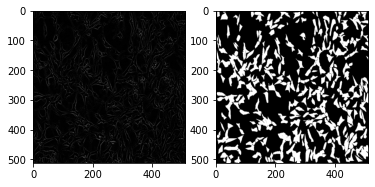

In [24]:
x = train_dataset.__iter__().next()
#tf.math.reduce_max(x)

plt.subplot(1,2,1)
plt.imshow(x[0][1,:,:], cmap="gray")
plt.subplot(1,2,2)
plt.imshow(x[1][1,:,:], cmap= "gray")
#x[0][1,: ,: ]
x = readt(train_masks[0], show=False)

( x.shape  ,  np.unique(  readt(train_masks[0], show=False)  ) )

## Building the DeepLabV3+ model

DeepLabv3+ extends DeepLabv3 by adding an encoder-decoder structure. The encoder module
processes multiscale contextual information by applying dilated convolution at multiple
scales, while the decoder module refines the segmentation results along object boundaries.

#![](https://github.com/lattice-ai/DeepLabV3-Plus/raw/master/assets/deeplabv3_plus_diagram.png)

**Dilated convolution:** With dilated convolution, as we go deeper in the network, we can keep the
stride constant but with larger field-of-view without increasing the number of parameters
or the amount of computation. Besides, it enables larger output feature maps, which is
useful for semantic segmentation.

The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the
sampling rate becomes larger, the number of valid filter weights (i.e., weights that
are applied to the valid feature region, instead of padded zeros) becomes smaller.

In [25]:

def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output



# def dice_losse(y_true, y_pred):
#     return (1 - dice_coe(y_true, y_pred))+tf.keras.losses.binary_crossentropy(y_true,y_pred)
# #
# # def dice_loss(y_true, y_pred):
# #     return 1 - dice_coe(y_true, y_pred)
# #
# #
# # def bce_dice_loss(y_true, y_pred):
# #     return  .5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + \
# #             (1 -.5) * dice_loss(y_true, y_pred)
#
# from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras import backend as K
#
# def dice_coef(y_true, y_pred, smooth=1):
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = tf.reduce_sum(y_true_f * y_pred_f)
#     return (2 * intersection + smooth) / ( tf.reduce_sum(y_true_f) +  tf.reduce_sum(y_pred_f) + smooth)
#
# def dice_loss(y_true, y_pred):
#     return (1 - dice_coef(y_true, y_pred))+tf.keras.losses.binary_crossentropy(y_true,y_pred)
#
# def bce_dice_loss(y_true, y_pred):
#     return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


The encoder features are first bilinearly upsampled by a factor 4, and then
concatenated with the corresponding low-level features from the network backbone that
have the same spatial resolution. For this example, we
use a ResNet50 pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.

In [26]:

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


def build_model(hp):
    #optimizer = hp.Choice("optimizer", ["adam", "RMSprop"])
    keras.backend.clear_session()
    learning_rate=hp.Choice("learning_rate", values=[ 1e-4,5e-4, 5e-5])
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
    model.compile(
    optimizer= keras.optimizers.Adam( learning_rate), # keras.optimizers.Adam(learning_rate=0.01),
    loss = loss,
    metrics= ["accuracy"] ) #["accuracy", dice_coe],
    return  model



tuner = kt.BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    #executions_per_trial=2,
    overwrite=True,
    directory= os.path.join(DATA_DIR,'models/logs'),
    project_name="helloworld2",
)

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

Search space summary
Default search space size: 1
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.0005, 5e-05], 'ordered': True}


In [27]:
tuner.search(train_dataset, epochs=30, validation_data=val_dataset, callbacks = [stop_early])
tuner.results_summary()


Trial 3 Complete [00h 09m 44s]
val_accuracy: 0.9297229647636414

Best val_accuracy So Far: 0.9297229647636414
Total elapsed time: 00h 24m 01s
INFO:tensorflow:Oracle triggered exit


In [28]:
tuner.results_summary()

Results summary
Results in C:/kaggletemp/sartorius-cell-instance-segmentation\models/logs\helloworld2
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 5e-05
Score: 0.9297229647636414
Trial summary
Hyperparameters:
learning_rate: 5e-05
Score: 0.9260039925575256
Trial summary
Hyperparameters:
learning_rate: 0.0001
Score: 0.8625295758247375


In [29]:
#tuner.reload()
#model = tuner.get_best_models()[0]
model = tuner.get_best_models(num_models=1)[0]

#tuner.results_summary()
#tuner.search_space_summary()


In [27]:
#best_hps = tuner.get_best_hyperparameters( num_trials=1)
#model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
#model = tuner.get_best_hyperparameters(best_hps)

In [15]:
os.path.join(DATA_DIR,'models/logs')


# CALLBACKS
checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join(DATA_DIR,'models/models_dice_loss.h5'),
                                                verbose= 1, monitor='val_accuracy', patience=5,
                                                mode='max', save_best_only=True)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coe', mode='max', patience=10,
                                              restore_best_weights=True)
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=0.00001)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join(DATA_DIR,'models/logs'))


In [14]:
#loss = keras.losses.binary_crossentropy
#loss = keras.SparseCategoricalCrossentropy#from_logits=True)
#loss = keras.losses.sparse_categorical_crossentropy
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     loss= loss,
#     metrics= [ dice_coe] ,
# )
#
# history = model.fit(train_dataset,
#                     validation_data=val_dataset,
#                     epochs=100,
#                     callbacks = [checkpoint, reduce,early_stop],
#                     )
auc = tf.keras.metrics.AUC(curve= "ROC")
def auc_metric( y_true, y_pred):
    # for i in range(y_pred.shape[0]):
    #     aux = y_pred[i,:,:]
    #     aux = tf.argmax(aux,axis=2)
    #     aux = au

    y_pred = tf.cast( tf.argmax(y_pred ,axis=3), tf.float32)  #( 4,512,512,3) selects the best channel returning (4,512,512)
    y_pred = tf.expand_dims ( y_pred , axis=3)
    y_pred = y_pred >=1
    y_pred = tf.cast(y_pred,tf.float32)
    y_true = y_true >=1
    y_true =  tf.cast( y_true, tf.float32)
    # y_pred = tf.reshape( y_pred, -1)
    # y_true = tf.reshape(y_true, -1)
    return auc(y_true , y_pred )

def dice_coe(y_true, y_pred, axis = None, smooth=1e-10):
    y_pred = tf.cast( tf.argmax(y_pred ,axis=3), tf.float32)  #( 4,512,512,3) selects the best channel returning (4,512,512)
    y_pred = tf.expand_dims ( y_pred , axis=3)

    it = tf.reduce_max(y_true)

    y_pred = y_pred >=1
    y_pred = tf.cast(y_pred,tf.float32)
    y_true = y_true >=1
    y_true =  tf.cast( y_true, tf.float32)

    inse = tf.reduce_sum(y_pred * y_true, axis=axis)
    l = tf.reduce_sum(y_pred, axis=axis)
    r = tf.reduce_sum(y_true, axis=axis)

    dice = (2. * inse + smooth) / (l + r + smooth)
    dice = tf.reduce_mean(dice, name='dice_coe')
    return dice
def dice_loss(y_true, y_pred, axis = None, smooth=1e-10):
    #out = 1- dice_coe(y_true,y_pred,axis= None , smooth = 1e-10)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred)
    loss = tf.cast(loss, tf.float32)
    dl = 1.0 - dice_coe(y_true,y_pred,axis= None , smooth = 1e-10)
    return  loss + dl #tf.reduce_sum( dl, loss, name= "diceloss")

# def dice_coe(target, output, axis = None, smooth=1e-10):
#     vectmax = ( [tf.reduce_max(output[:,:,0]),
#                  tf.reduce_max(output[:,:,1]),
#                  tf.reduce_max(output[:,:,2]),
#                  tf.reduce_max(output[:,:,3]) ])
#     vectmax = tf.cast(vectmax ,tf.float32)
#     wmax = tf.cast( tf.argmax(vectmax, axis= 0, name=None), tf.float32)
#     outputx = tf.cast( tf.argmax(output, axis= 2), tf.float32)
#     outputx = tf.expand_dims(outputx, axis = 2)
#     output = outputx//(wmax)
#
#     # target = np.array(target)
#     # outputx = np.array(outputx)
#     # target_idx = target >=1
#     # target[target_idx] = 1
#     # output_idx = outputx >= 1
#     # ouput[output_idx ] = 1
#     tmax = tf.cast (tf.reduce_max(target), tf.float32)
#     if tmax == wmax:
#         target =  target//tmax
#     else:
#         target = tf.zeros(target.shape)
#
#     output = tf.dtypes.cast( tf.math.greater(output, 0.5), tf.float32 )
#     target = tf.dtypes.cast( tf.math.greater(target, 0.5), tf.float32 )
#     inse = tf.reduce_sum(output * target, axis=axis)
#     l = tf.reduce_sum(output, axis=axis)
#     r = tf.reduce_sum(target, axis=axis)
#
#     dice = (2. * inse + smooth) / (l + r + smooth)
#     dice = tf.reduce_mean(dice, name='dice_coe')
#     return dice
#
# loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# msim = tf.keras.losses.CosineSimilarity(axis = 2, name = "cos")  #metrics.AUC(from_logits=True, ) 6t
# prec = tf.keras.metrics.Precision(name= "prec")
# # model.compile(
# #     optimizer=keras.optimizers.Adam(learning_rate=0.01),
# #     loss= [dice_loss],
# #     metrics= ["accuracy"]#["accuracy", dice_coe],
# # )
#
# history = model.fit(train_dataset,
#                     validation_data=val_dataset,
#                     epochs=30,
#                     #callbacks = [checkpoint, reduce,tensorboard_callback],
# )
# history = pd.DataFrame(history.history)
# history.to_csv( os.path.join(DATA_DIR,'models/history.csv'))

In [5]:
# %load_ext tensorboard
# %tensorboard --logdir C:/kaggletemp/sartorius-cell-instance-segmentation/models/logs
from tensorboard import program

# tracking_address = os.path.join(DATA_DIR,'models/logs') # the path of your log file.

# if __name__ == "__main__":
#     tb = program.TensorBoard()
#     tb.configure(argv=[None, '--logdir', tracking_address])
#     url = tb.launch()
#     print(f"Tensorflow listening on {url}")

Tensorflow listening on http://localhost:6006/


In [17]:

# plt.plot(history.history["loss"])
# plt.title("Training Loss")
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.show()
#
# plt.plot(history.history["accuracy"])
# plt.title("Training Accuracy")
# plt.ylabel("accuracy")
# plt.xlabel("epoch")
# plt.show()
#
# plt.plot(history.history["val_loss"])
# plt.title("Validation Loss")
# plt.ylabel("val_loss")
# plt.xlabel("epoch")
# plt.show()
#
# plt.plot(history.history["val_accuracy"])
# plt.title("Validation Accuracy")
# plt.ylabel("val_accuracy")
# plt.xlabel("epoch")
# plt.show()
# pd.DataFrame(history.history)


NameError: name 'history' is not defined

## Inference using Colormap Overlay

The raw predictions from the model represent a one-hot encoded tensor of shape `(N, 512, 512, 20)`
where each one of the 20 channels is a binary mask corresponding to a predicted label.
In order to visualize the results, we plot them as RGB segmentation masks where each pixel
is represented by a unique color corresponding to the particular label predicted. We can easily
find the color corresponding to each label from the `human_colormap.mat` file provided as part
of the dataset. We would also plot an overlay of the RGB segmentation mask on the input image as
this further helps us to identify the different categories present in the image more intuitively.

In [18]:
# #model <- tf.
# # Loading the Colormap
# colormap = loadmat(
#     "C:/kaggletemp/sartorius-cell-instance-segmentation/instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
# )["colormap"]
# colormap = colormap * 100
# colormap = colormap.astype(np.uint8)
# #colormap = colormap[0:3]
# colormap = colormap[[0,7,10,15],:]
# #colormap = np.array ( [[1,0,0],[0,1,0],[0,0,1]] )
# colormap = np.array([
#     [0,0,0],
#     [0,128,128],
#     [0,128,0],
#     [0,0,128]]
# )
# colormap

In [30]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims(image_tensor, axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


# def plot_predictions(images_list, colormap, model):
#     for image_file in images_list:
#         image_tensor = read_image(image_file)
#         prediction_mask = infer(image_tensor=image_tensor, model=model)
#         prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 3)
#         overlay = get_overlay(image_tensor, prediction_colormap)
#         plot_samples_matplotlib(
#             [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
#         )
def plot_predictions(images_list, mask_list,  colormap, model):
    for image_file, mask_file in zip(images_list,mask_list) :
        image_tensor = read_image(image_file)
        mask_tensor = read_image(mask_file, mask=True)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 4)
        #overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, mask_tensor, prediction_colormap], figsize=(18, 14)
        )

In [31]:
x = train_images[:4]
image_tensor = read_image(x[0])
mask= infer(image_tensor=image_tensor, model=model)
mask = np.ndarray.flatten(mask)
np.unique(mask)


array([0, 1], dtype=int64)

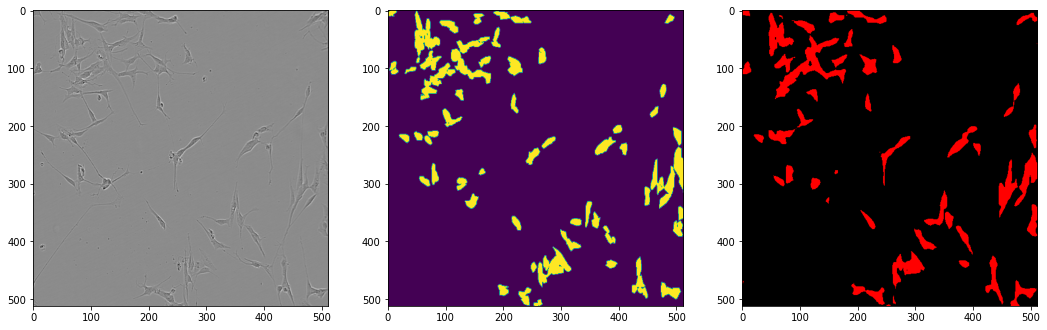

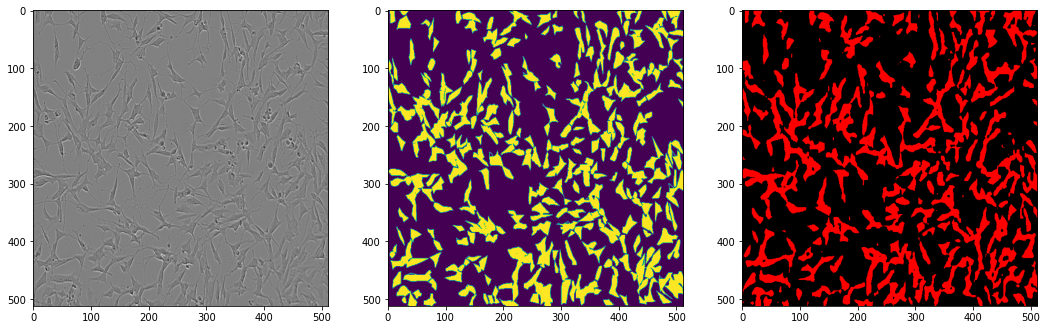

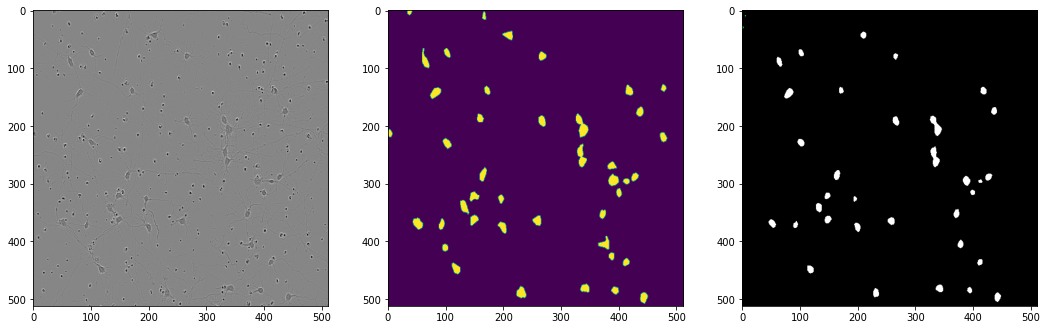

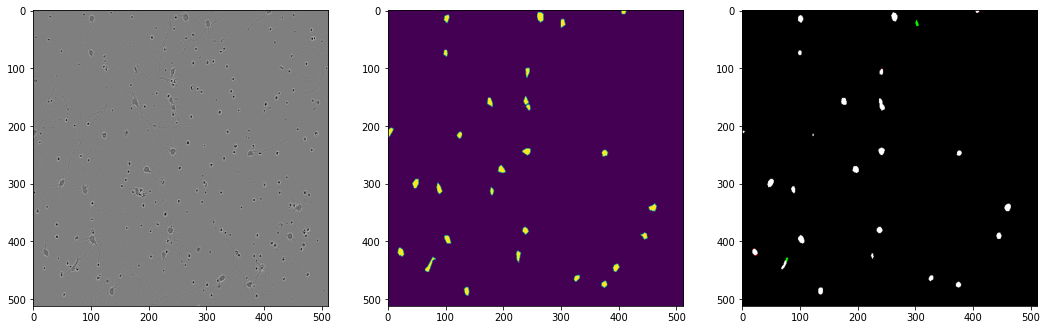

In [32]:
colormap = np.array([
    [0,0,0],
    [128,0,0], #red
    [0,128,0], #green
    [128,128,128]] #yellow
)
plot_predictions(train_images[:4],  train_masks[:4] ,colormap, model=model)

### Inference on Validation Images

In [ ]:
#plot_predictions(val_images[:40], val_masks[:40],colormap, model=model)

In [33]:
# Reference: https://www.kaggle.com/ihelon/cell-segmentation-run-length-decoding
#https://www.kaggle.com/susnato/understanding-run-length-encoding-and-decoding?scriptVersionId=77552323
# coding packed into one function

def rle_decode(mask_rle, shape, color=3):     #color=1,3
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return
    color: color for the mask
    Returns numpy array (mask)
    '''
    s = mask_rle.split()

    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]

    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)

    for start, end in zip(starts, ends):
        img[start : end] = color

    return img.reshape(shape)

# other version
# https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/291627
def rle_decode(mask_rle, shape=(520, 704, 1)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)



array([0, 1], dtype=uint8)

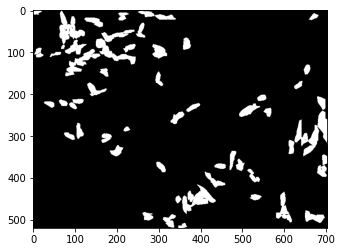

In [34]:
mask = readt( train_masks[0], show = False)
#img = rle_decode(mask)
plt.imshow(mask, cmap="gray");
np.unique(mask)

1/1 [==============================] - 0s 16ms/step


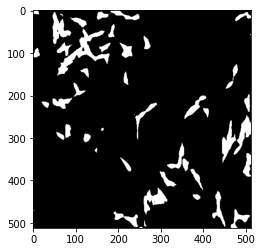

In [35]:
test = glob(os.path.join(DATA_DIR, "test/*"))
x = read_image(train_images[0], mask =False)
#x = tf.image.resize(images=x, size=[IMAGE_SIZE, IMAGE_SIZE])
x = tf.expand_dims(x,0)
preds_test = model.predict(x, verbose=1)

preds_test = np.argmax( preds_test, axis=3)
preds_test = preds_test[0,:,:]
np.unique(preds_test)
preds_test.shape
plt.imshow(preds_test, cmap= "gray")

In [103]:
X_test = data_generator(test, BATCH_SIZE = 1) # batchsize < BATCH_SIZE is not permited in predict step
X_test

<BatchDataset shapes: (1, 512, 512, 3), types: tf.float32>

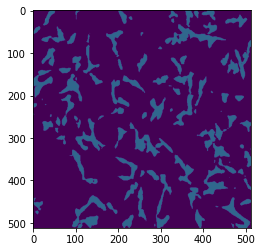

In [36]:
    image_test = read_image(test[0], mask = False)
    image_test = infer(model, image_test)
    plt.imshow(image_test)

array([0, 1], dtype=uint8)

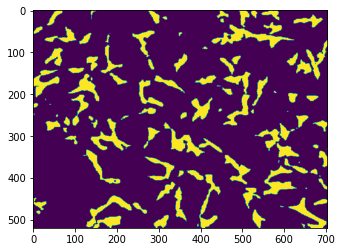

In [37]:
Y_test = []
for image_test in test:
    pred = read_image(image_test, mask = False)
    pred = infer(model, pred)
    pred = tf.expand_dims(pred,axis = 2)
    pred = tf.image.resize(pred,size=(520,704))
    pred = pred > .5
    pred = tf.cast(pred , dtype= tf.uint8)
    pred = pred.numpy()
    Y_test.append(pred)
Y_test[0].shape
plt.imshow(Y_test[0])
np.unique(Y_test[0])
#X_test = [read_image(i, mask= False) for i in test]
# X_test = tf.concat(X_test,axis=0)
# preds_test = model.predict( X_test)
# preds_test_t = (preds_test > 0.5).astype(np.uint8)
# preds_test_t = tf.image.resize(preds_test_t, size=(704,520))
# preds_test_t.shape
#preds_test_t = cv2.resize(preds_test_t,dsize=(704,520),interpolation=cv2.INTER_CUBIC).reshape(520,704,1)

In [108]:
#test_masks = [cv2.resize(pred,dsize=(704,520),interpolation=cv2.INTER_CUBIC).reshape(520,704,1) for pred in preds_test_t]


ValueError: cannot reshape array of size 1464320 into shape (520,704,1)

In [49]:
def check_overlap(msk):
    msk = msk.astype(np.bool).astype(np.uint8)
    return np.any(np.sum(msk, axis=-1)>1)

def fix_overlap(msk):
    """
    Args:
        mask: multi-channel mask, each channel is an instance of cell, shape:(520,704,None)
    Returns:
        multi-channel mask with non-overlapping values, shape:(520,704,None)
    """
    msk = np.array(msk)
    msk = np.pad(msk, [[0,0],[0,0],[1,0]])
    ins_len = msk.shape[-1]
    msk = np.argmax(msk,axis=-1)
    msk = tf.keras.utils.to_categorical(msk, num_classes=ins_len)
    msk = msk[...,1:]
    msk = msk[...,np.any(msk, axis=(0,1))]
    return msk

def remove_isolated_points_from_rle(strin):
    t2 = strin.split(" ")
    a = []
    for i in range(0, len(t2), 2):
        if t2[i+1]!="1":
            a.append(t2[i])
            a.append(t2[i+1])
    return ' '.join(a)

# split the mask into each cluster nucleus for the submision
# seen on https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/288376
def post_process(mask, min_size=30, shape=(520, 704,)):
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = []
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            a_prediction = np.zeros(shape, np.float32)
            a_prediction[p] = 1
            predictions.append(a_prediction)
    return predictions



112


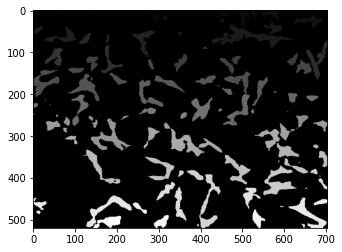

In [38]:
# connectedComponents returns the number of compenets of the image and a image with a pixel value of each of them
num_component, component = cv2.connectedComponents(Y_test[0])
print(num_component)
plt.imshow(component, cmap="gray");

In [46]:
import os
#path = os.path.normpath(test[0])
#path.split(os.sep)
path, file = os.path.split(test[1])
id =  file.split(".png")[0]
id

'd48ec7815252'

(520, 704)

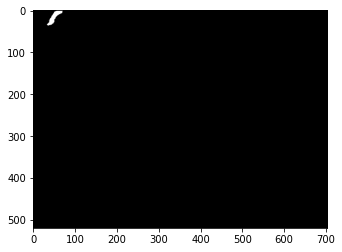

In [52]:
#Y_test = []
pn = []
pid = []
for index, image_test in enumerate(test):
    path, file = os.path.split(image_test)
    id =  file.split(".png")[0]
    pred = read_image(image_test, mask = False)
    pred = infer(model, pred)
    pred = tf.expand_dims(pred,axis = 2)
    pred = tf.image.resize(pred,size=(520,704))
    pred = pred > .5
    pred = tf.cast(pred , dtype= tf.uint8)
    pred = pred.numpy()
    nucleus = post_process(pred)
    for nucl in nucleus:
        pn.append(nucl)
        pid.append(id)

plt.imshow(pn[0], cmap="gray");
pn[0].shape


In [53]:
predicted2 = [rle_encode(test_mask2) for test_mask2 in pn]
print(predicted2[0])
predicted_filt = [remove_isolated_points_from_rle(s) for s in predicted2]
print(predicted_filt[0])

57 15 761 15 1464 16 2165 18 2868 19 3571 20 4275 20 4979 19 5681 18 6385 17 7088 15 7792 14 8495 13 9198 13 9901 13 10605 12 11309 11 12012 11 12716 11 13418 13 14122 12 14825 12 15529 11 16232 12 16937 11 17639 13 18343 13 19048 12 19752 12 20455 12 21158 12 21861 13 22564 12 23267 12 23970 12 24675 8 25380 3
57 15 761 15 1464 16 2165 18 2868 19 3571 20 4275 20 4979 19 5681 18 6385 17 7088 15 7792 14 8495 13 9198 13 9901 13 10605 12 11309 11 12012 11 12716 11 13418 13 14122 12 14825 12 15529 11 16232 12 16937 11 17639 13 18343 13 19048 12 19752 12 20455 12 21158 12 21861 13 22564 12 23267 12 23970 12 24675 8 25380 3


In [57]:
# submision sample
sample_submission=pd.read_csv(DATA_DIR + '/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head()

(3, 2)


,id,predicted
0,7ae19de7bc2a,NaN
1,d48ec7815252,NaN
2,d8bfd1dafdc4,NaN


In [58]:
submit = sample_submission.copy()
submit = pd.DataFrame({'id':id, 'predicted':predicted_filt})
print(submit.shape)
submit.head()
#submit.to_csv('submission.csv', index=False)

(112, 2)


,id,predicted
0,d8bfd1dafdc4,57 15 761 15 1464 16 2165 18 2868 19 3571 20 4...
1,d8bfd1dafdc4,140 12 844 12 1548 11 2252 8 2955 6 3659 6 436...
2,d8bfd1dafdc4,277 7 981 7 1685 9 2389 11 3093 14 3799 13 450...
3,d8bfd1dafdc4,447 5 1151 5 1855 6 2559 8 3263 9 3967 10 4671...
4,d8bfd1dafdc4,493 18 1197 18 1901 18 2605 19 3311 19 4015 19...


In [59]:
## Submitting

In [ ]:
submit.to_csv('submission.csv', index=False)

In [68]:
tf.__version__


'2.6.0'